<a href="https://colab.research.google.com/github/Adityainsight/Machine-Learning/blob/main/Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for RELIANCE.NS...
RELIANCE.NS columns: ['Adj Close_RELIANCE.NS', 'Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS', 'Open_RELIANCE.NS', 'Volume_RELIANCE.NS']
Fetching data for NSEI.NS...


ERROR:yfinance:HTTP Error 404: 
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NSEI.NS']: YFTzMissingError('possibly delisted; no timezone found')


NSEI.NS columns: ['Adj Close_NSEI.NS', 'Close_NSEI.NS', 'High_NSEI.NS', 'Low_NSEI.NS', 'Open_NSEI.NS', 'Volume_NSEI.NS']
Fetching data for ^IXIC...
^IXIC columns: ['Adj Close_^IXIC', 'Close_^IXIC', 'High_^IXIC', 'Low_^IXIC', 'Open_^IXIC', 'Volume_^IXIC']
Fetching data for AAPL...
AAPL columns: ['Adj Close_AAPL', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']
✅ Intraday data collection complete.
                           Adj Close_RELIANCE.NS  Close_RELIANCE.NS  \
2025-09-11 09:45:00+00:00            1382.800049        1382.800049   
2025-09-11 09:50:00+00:00            1382.300049        1382.300049   
2025-09-11 09:55:00+00:00            1383.300049        1383.300049   
2025-09-11 15:55:00+00:00                    NaN                NaN   
2025-09-11 16:00:00+00:00                    NaN                NaN   
2025-09-11 16:05:00+00:00                    NaN                NaN   
2025-09-11 16:00:00+00:00                    NaN                NaN   
2025-09-11 16:

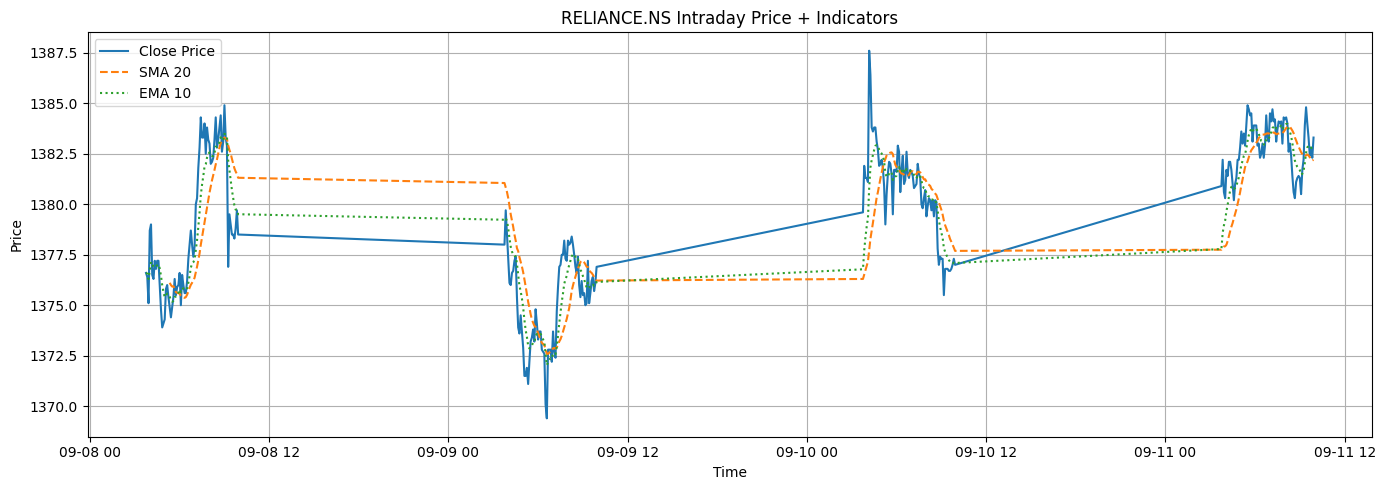

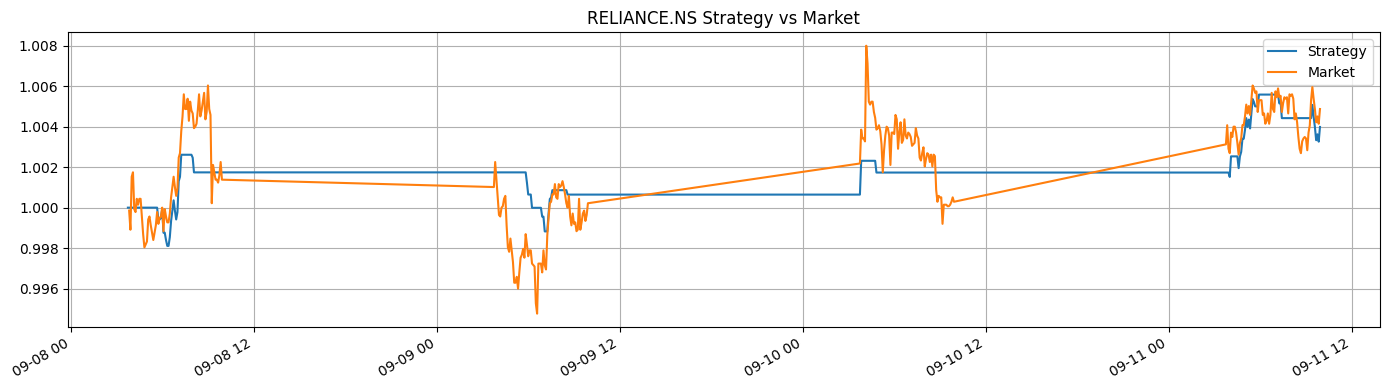


📊 RELIANCE.NS Strategy Summary:
Total Strategy Return: 0.40%
Win Rate: 9.67%



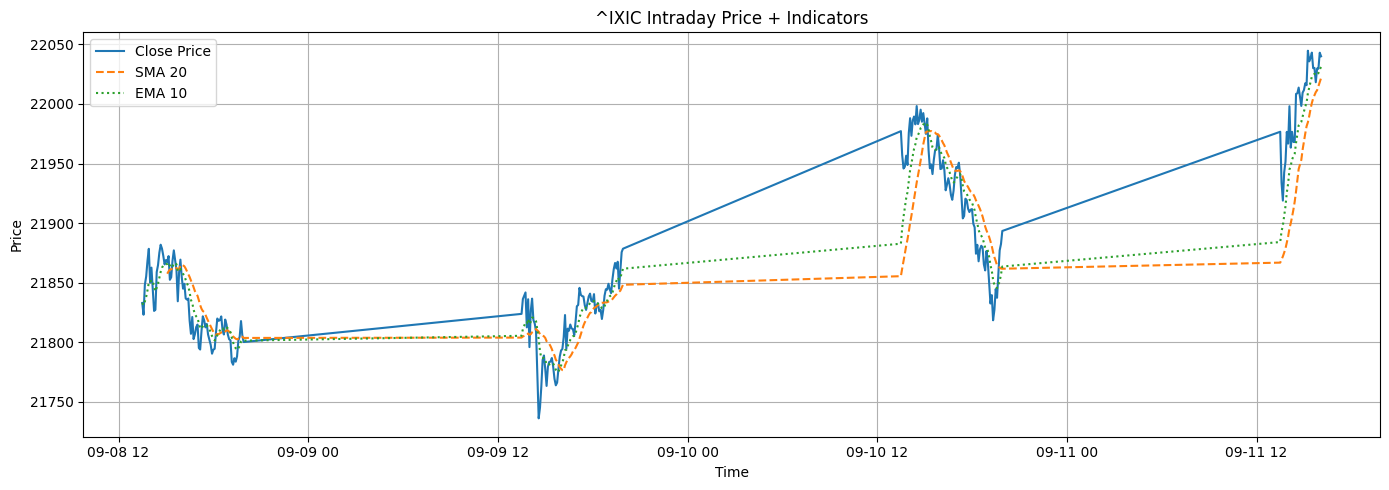

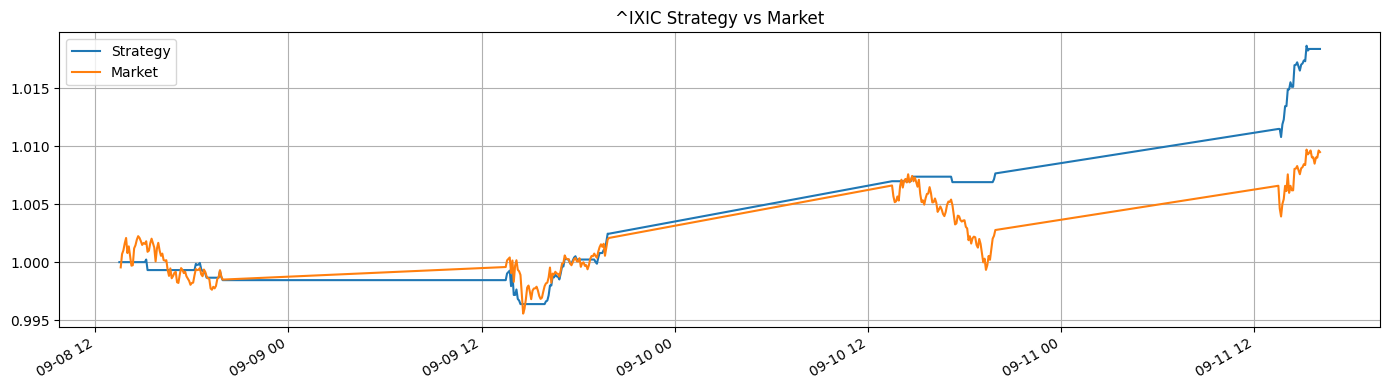


📊 ^IXIC Strategy Summary:
Total Strategy Return: 1.82%
Win Rate: 16.79%



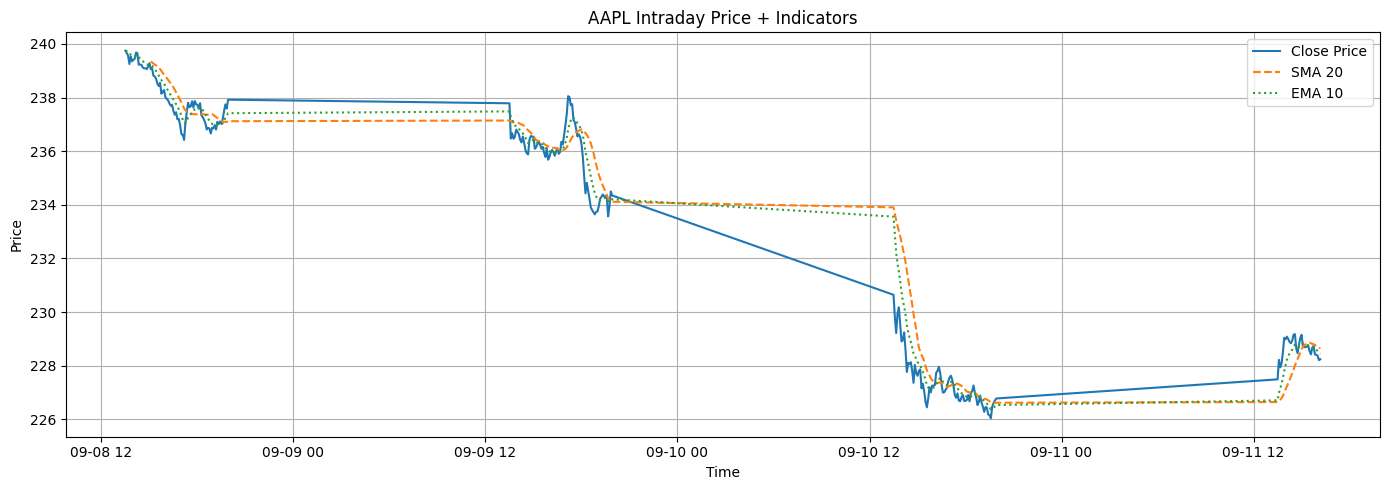

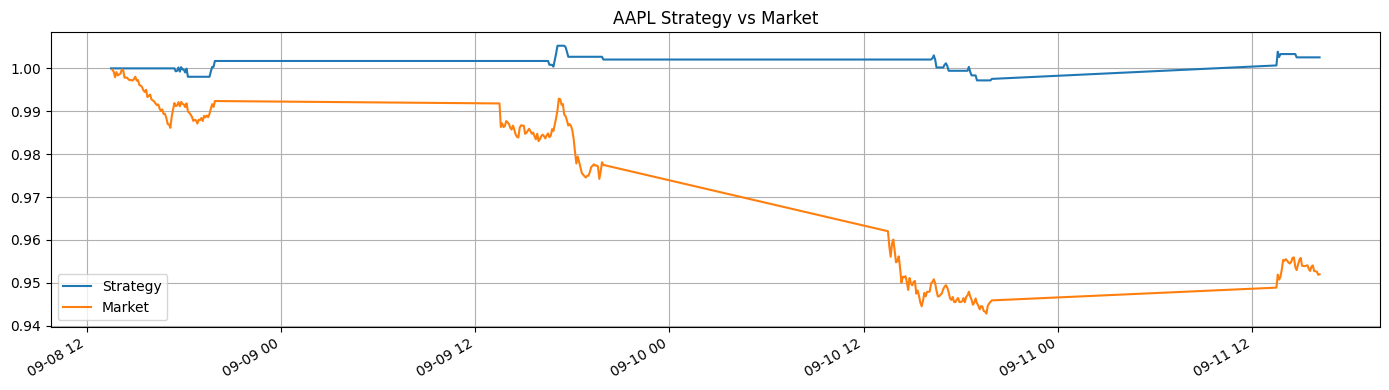


📊 AAPL Strategy Summary:
Total Strategy Return: 0.26%
Win Rate: 7.12%



In [1]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Define stock symbols
indian_tickers = ['RELIANCE.NS', 'NSEI.NS']
us_tickers = ['^IXIC', 'AAPL']

# Time settings
end = datetime.datetime.now()
start = end - datetime.timedelta(days=6)
interval = '5m'

def fetch_intraday_data(ticker):
    print(f"Fetching data for {ticker}...")
    df = yf.download(
        ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=False,
        progress=False
    )

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    print(f"{ticker} columns:", df.columns.tolist())

    close_cols = [col for col in df.columns if 'close' in col.lower()]
    if not close_cols:
        raise ValueError(f"No valid 'Close' column in: {df.columns.tolist()}")

    close_col = close_cols[0]
    df = df.dropna(subset=[close_col]).copy()
    df['Close'] = df[close_col]
    df['Ticker'] = ticker
    return df

frames = []
for symbol in indian_tickers + us_tickers:
    try:
        df = fetch_intraday_data(symbol)
        frames.append(df)
    except Exception as e:
        print(f"❌ Error fetching {symbol}: {e}")

if frames:
    combined_df = pd.concat(frames)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    csv_filename = f"intraday_combined_{timestamp}.csv"
    combined_df.to_csv(csv_filename)

    print("✅ Intraday data collection complete.")
    print(combined_df.groupby('Ticker').tail(3))

    for symbol in combined_df['Ticker'].unique():
        df_symbol = combined_df[combined_df['Ticker'] == symbol].copy()

        if ('Close' not in df_symbol.columns) or (not isinstance(df_symbol['Close'], pd.Series)) or (df_symbol['Close'].isnull().all()):
            print(f"⚠️ Skipping {symbol} due to missing or invalid Close data.")
            continue

        df_symbol['Close'] = df_symbol['Close'].astype(float)

        # Add indicators manually using rolling methods (no pandas_ta)
        df_symbol['SMA_20'] = df_symbol['Close'].rolling(window=20).mean()
        df_symbol['EMA_10'] = df_symbol['Close'].ewm(span=10, adjust=False).mean()

        # Manual RSI Calculation
        delta = df_symbol['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df_symbol['RSI'] = 100 - (100 / (1 + rs))

        # Manual MACD Calculation
        ema12 = df_symbol['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df_symbol['Close'].ewm(span=26, adjust=False).mean()
        df_symbol['MACD'] = ema12 - ema26
        df_symbol['MACD_signal'] = df_symbol['MACD'].ewm(span=9, adjust=False).mean()

        # Signal Logic
        df_symbol['Signal'] = 0
        df_symbol.loc[
            (df_symbol['Close'] > df_symbol['SMA_20']) &
            (df_symbol['MACD'] > df_symbol['MACD_signal']) &
            (df_symbol['RSI'].between(40, 70)),
            'Signal'
        ] = 1

        df_symbol['Position'] = df_symbol['Signal'].shift()
        df_symbol['Market_Returns'] = df_symbol['Close'].pct_change()

        # Stop-loss and take-profit logic
        df_symbol['Strategy_Returns'] = 0.0
        entry_price = None
        for i in range(1, len(df_symbol)):
            if df_symbol['Position'].iloc[i] == 1 and df_symbol['Position'].iloc[i-1] != 1:
                entry_price = df_symbol['Close'].iloc[i]
            if df_symbol['Position'].iloc[i] == 1 and entry_price:
                change = (df_symbol['Close'].iloc[i] - entry_price) / entry_price
                if change <= -0.01:
                    df_symbol.at[df_symbol.index[i], 'Position'] = 0
                elif change >= 0.02:
                    df_symbol.at[df_symbol.index[i], 'Position'] = 0
            df_symbol.at[df_symbol.index[i], 'Strategy_Returns'] = df_symbol['Market_Returns'].iloc[i] * df_symbol['Position'].iloc[i]

        # Plot price with indicators
        plt.figure(figsize=(14, 5))
        plt.plot(df_symbol.index, df_symbol['Close'], label='Close Price')
        plt.plot(df_symbol.index, df_symbol['SMA_20'], label='SMA 20', linestyle='--')
        plt.plot(df_symbol.index, df_symbol['EMA_10'], label='EMA 10', linestyle=':')
        plt.title(f"{symbol} Intraday Price + Indicators")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Equity Curve
        plt.figure(figsize=(14, 4))
        (df_symbol['Strategy_Returns'] + 1).cumprod().plot(label='Strategy')
        (df_symbol['Market_Returns'] + 1).cumprod().plot(label='Market')
        plt.title(f"{symbol} Strategy vs Market")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        total_return = df_symbol['Strategy_Returns'].sum()
        win_rate = (df_symbol['Strategy_Returns'] > 0).mean() * 100
        print(f"\n📊 {symbol} Strategy Summary:")
        print(f"Total Strategy Return: {total_return:.2%}")
        print(f"Win Rate: {win_rate:.2f}%\n")
else:
    print("⚠️ No data collected for any ticker.")